In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zillow-prize-1/properties_2017.csv
/kaggle/input/zillow-prize-1/sample_submission.csv
/kaggle/input/zillow-prize-1/zillow_data_dictionary.xlsx
/kaggle/input/zillow-prize-1/train_2016_v2.csv
/kaggle/input/zillow-prize-1/properties_2016.csv
/kaggle/input/zillow-prize-1/train_2017.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from lightgbm.sklearn import LGBMRegressor
from sklearn.preprocessing import StandardScaler

import optuna
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import KFold
from functools import partial



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_prop_df = pd.read_csv('/kaggle/input/zillow-prize-1/properties_2016.csv')
test_prop_df = pd.read_csv('/kaggle/input/zillow-prize-1/properties_2017.csv')

/tmp/ipykernel_23/370078774.py:1: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  train_prop_df = pd.read_csv('/kaggle/input/zillow-prize-1/properties_2016.csv')
/tmp/ipykernel_23/370078774.py:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  test_prop_df = pd.read_csv('/kaggle/input/zillow-prize-1/properties_2017.csv')


In [4]:
train_y = pd.read_csv('/kaggle/input/zillow-prize-1/train_2016_v2.csv')
test_y = pd.read_csv('/kaggle/input/zillow-prize-1/train_2017.csv')

In [5]:
train_df = train_prop_df.merge(right = train_y, how='inner', on='parcelid')
# test_df = test_prop.merge(right = test_y, how='inner', on='parcelid')
test_df = test_prop_df.copy()

In [6]:
train_df.shape,test_df.shape

((90275, 60), (2985217, 58))

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      90275 non-null  int64  
 1   airconditioningtypeid         28781 non-null  float64
 2   architecturalstyletypeid      261 non-null    float64
 3   basementsqft                  43 non-null     float64
 4   bathroomcnt                   90275 non-null  float64
 5   bedroomcnt                    90275 non-null  float64
 6   buildingclasstypeid           16 non-null     float64
 7   buildingqualitytypeid         57364 non-null  float64
 8   calculatedbathnbr             89093 non-null  float64
 9   decktypeid                    658 non-null    float64
 10  finishedfloor1squarefeet      6856 non-null   float64
 11  calculatedfinishedsquarefeet  89614 non-null  float64
 12  finishedsquarefeet12          85596 non-null  float64
 13  f

Removing outliers

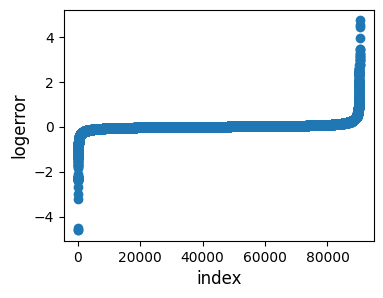

In [8]:
plt.figure(figsize=(4,3))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

<AxesSubplot: xlabel='logerror', ylabel='Count'>

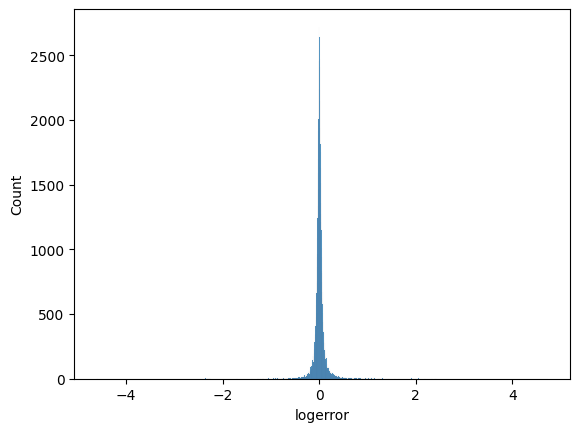

In [9]:
sns.histplot(data=train_df, x='logerror')

In [10]:
ulimit = train_df['logerror'].quantile(0.95)
llimit = train_df['logerror'].quantile(0.05)
print(ulimit, llimit)

0.1647 -0.1267


In [11]:
train_df = train_df[train_df['logerror']<ulimit]
train_df = train_df[train_df['logerror']>llimit]

In [12]:
# test_df = test_df[test_df['logerror']<ulimit]
# test_df = test_df[test_df['logerror']>llimit]

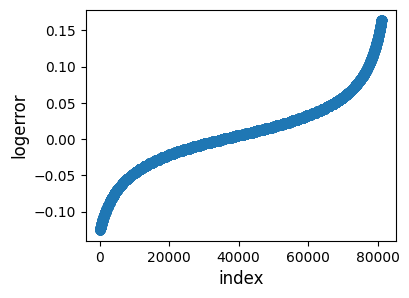

In [13]:
plt.figure(figsize=(4,3))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Deleting column with NAN

In [14]:
threshold = 0.7
nan = train_df.isnull().sum()/len(train_df)
usable = nan[nan < threshold].index.to_list()
disable = nan[nan >= threshold].index.to_list()
print(len(usable))
usable

35


['parcelid',
 'airconditioningtypeid',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'logerror',
 'transactiondate']

In [15]:
# train_df['airconditioningtypeid'].value_counts() 
# train_df['regionidcity'].value_counts() 
# train_df['regionidcounty'].value_counts() 
# train_df['regionidzip'].value_counts() 
# train_df['propertycountylandusecode'].value_counts() 
# train_df['fips'].value_counts() 
# train_df['propertylandusetypeid'].value_counts() 
# train_df['rawcensustractandblock'].value_counts() 
# train_df['propertyzoningdesc'].value_counts() 
# train_df['censustractandblock'].value_counts() 

In [16]:
train_df_new = train_df[usable].copy()

In [17]:
usable_test = [x for x in usable if x not in [ 'logerror', 'transactiondate']]
test_df_new = test_df[usable_test].copy()

missing value

In [18]:
import datetime as dt
train_df_new['age'] = dt.datetime.now().year - train_df_new['yearbuilt'] 
test_df_new['age'] = dt.datetime.now().year - test_df_new['yearbuilt']

In [19]:
cat_columns = ['airconditioningtypeid', 'buildingqualitytypeid', 'fips', 
'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid', 'rawcensustractandblock', 'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 
'regionidzip', 'location']

num_columns = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt',
       'unitcnt', 'age', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

In [20]:
cat_columns

['airconditioningtypeid',
 'buildingqualitytypeid',
 'fips',
 'heatingorsystemtypeid',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'propertyzoningdesc',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'location']

In [21]:
num_columns

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'lotsizesquarefeet',
 'roomcnt',
 'unitcnt',
 'age',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount']

In [22]:
# impute missing value with mean and mode

def replace_missing_data(df, mis_vars):
    print('##### Replacing missing values with mode of features #####')
    for var in mis_vars:
        if var in cat_columns:
            df[var] = df[var].fillna(df[var].mode()[0])
        else:
            df[var] = df[var].fillna(df[var].mean())
    return df

In [23]:
mis_var = [var for var in test_df_new.columns if test_df_new[var].isnull().sum() > 0]
test_df_new = replace_missing_data(test_df_new, mis_var)

##### Replacing missing values with mode of features #####


In [24]:
mis_var = [var for var in train_df_new.columns if train_df_new[var].isnull().sum() > 0]
train_df_new = replace_missing_data(train_df_new, mis_var)

##### Replacing missing values with mode of features #####


In [25]:
train_df_new['timestamp'] = pd.to_datetime(train_df_new['transactiondate'])
# test_df_new['timestamp'] = pd.to_datetime(test_df_new['transactiondate'])

Abnormality removal

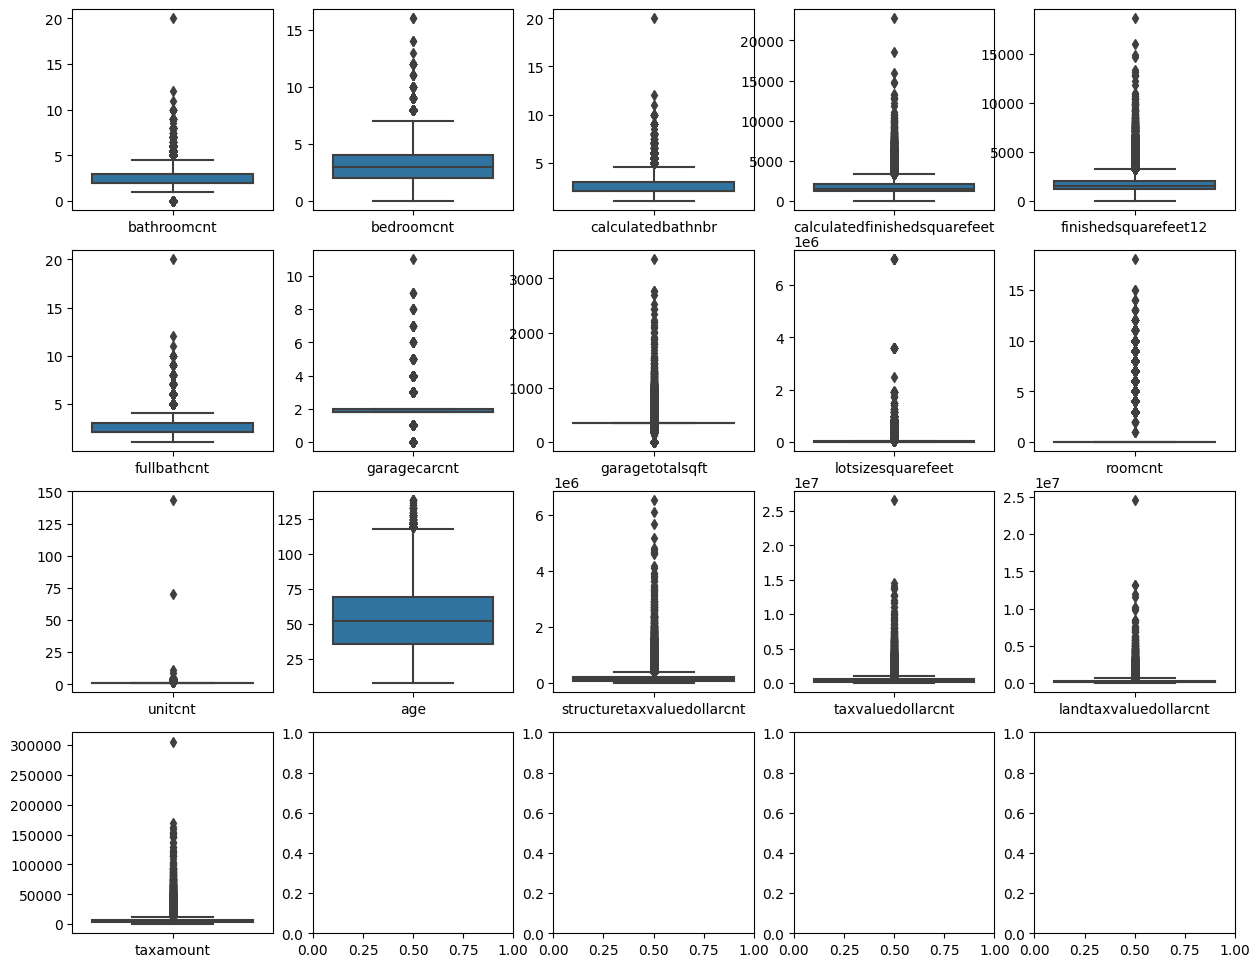

In [26]:
fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharex=False, sharey=False)

for i, ax in enumerate(axs.flat):
    if i < len(num_columns):
        sns.boxplot(x='variable', y='value', data=train_df_new[[train_df_new[num_columns].columns[i]]].melt(var_name='variable', value_name='value'), ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        # ax.set_title(num_columns[i])
plt.show()

In [27]:
quantile_values = train_df_new[num_columns].quantile(0.97)
for col in num_columns:
    train_df_new = train_df_new[train_df_new[col] < quantile_values[col]]

In [28]:
quantile_values = test_df_new[num_columns].quantile(0.97)
for col in num_columns:
    test_df_new = test_df_new[test_df_new[col] < quantile_values[col]]

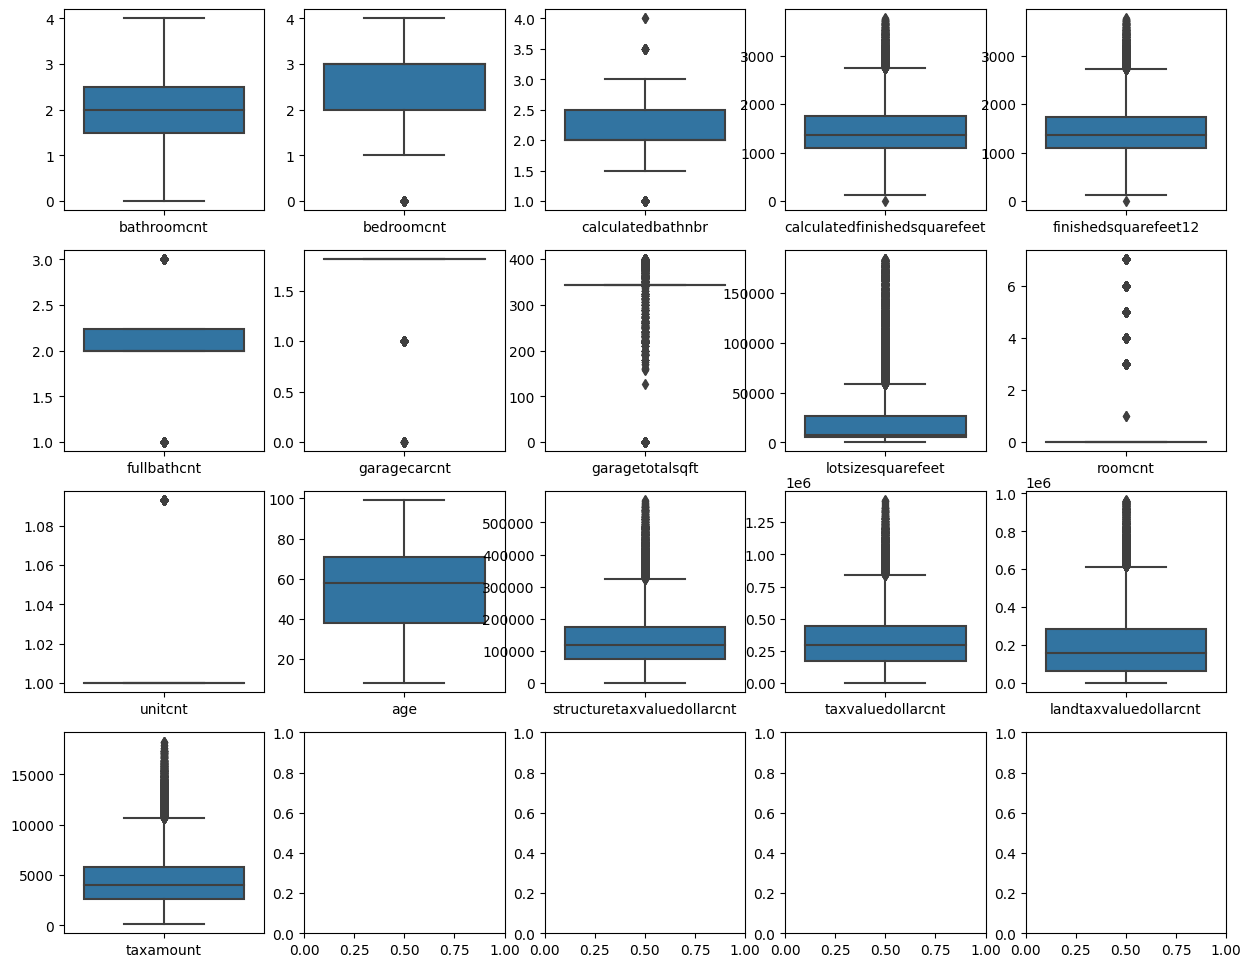

In [29]:
fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharex=False, sharey=False)

for i, ax in enumerate(axs.flat):
    if i < len(num_columns):
        sns.boxplot(x='variable', y='value', data=train_df_new[[train_df_new[num_columns].columns[i]]].melt(var_name='variable', value_name='value'), ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        # ax.set_title(num_columns[i])
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot: xlabel='latitude', ylabel='longitude'>

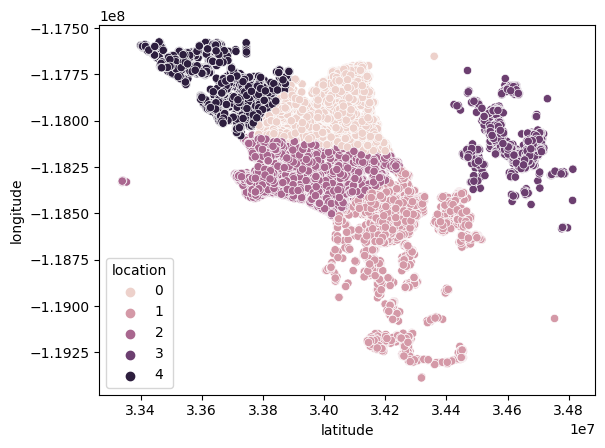

In [30]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil_scores = []
k_candidates = range(2, 11)

kmeans = KMeans(n_clusters=5, random_state=42)
train_df_new['location'] = kmeans.fit_predict(train_df_new[['latitude', 'longitude']])
sns.scatterplot(data=train_df_new, x='latitude', y='longitude', hue='location')

In [31]:
test_df_new['location'] = kmeans.predict(test_df_new[['latitude', 'longitude']])

In [32]:
train_df_new.columns

Index(['parcelid', 'airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'logerror', 'transactiondate',
       'age', 'timestamp', 'location'],
      dtype='object')

In [33]:
#seperating categorical and numerical features
y_train = train_df_new['logerror']
# cat_columns = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'fips', 
# 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid', 'rawcensustractandblock', 'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 
# 'regionidzip', 'storytypeid', 'typeconstructiontypeid', 'location']

cat_columns = ['airconditioningtypeid', 'buildingqualitytypeid', 'fips', 
'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid', 'rawcensustractandblock', 'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 
'regionidzip', 'location']

# drop_columns = ['latitude', 'longitude', 'parcelid', 'fireplaceflag', 'assessmentyear', 'taxdelinquencyflag', 'censustractandblock', 'logerror', 'transactiondate', 'timestamp', 'hashottuborspa',
# 'pooltypeid10', 'pooltypeid2', 'pooltypeid7']

drop_columns = ['latitude', 'longitude', 'parcelid', 'assessmentyear', 'censustractandblock', 'logerror', 'transactiondate', 'timestamp']

X_cat = train_df_new[cat_columns].astype('category')
X_num = train_df_new.drop(columns=cat_columns, axis=1).drop(columns=drop_columns, axis=1)
X_num.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet', 'roomcnt',
       'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'age'],
      dtype='object')

In [34]:
# y_test = test_df_new['logerror']
drop_columns_test = ['latitude', 'longitude', 'parcelid', 'assessmentyear', 'censustractandblock']

X_cat_test = test_df_new[cat_columns].astype('category')
X_num_test = test_df_new.drop(columns=cat_columns, axis=1).drop(columns=drop_columns_test, axis=1)

In [35]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.preprocessing import StandardScaler

In [36]:
#scaling
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_num)
X_scale = pd.DataFrame(data = X_scale, index=X_num.index, columns = X_num.columns)

In [37]:
#test set scaling
scaler_t = StandardScaler()
X_scale_t = scaler_t.fit_transform(X_num_test)
X_scale_t = pd.DataFrame(data = X_scale_t, index=X_num_test.index, columns = X_num_test.columns)

Merging categorical and numerical attributes

In [38]:
X = pd.concat([X_scale, X_cat], axis=1)

In [39]:
X_test = pd.concat([X_scale_t, X_cat_test], axis=1)

Checking multi attribute

/tmp/ipykernel_23/348998257.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=X.corr(), annot=True)


<AxesSubplot: >

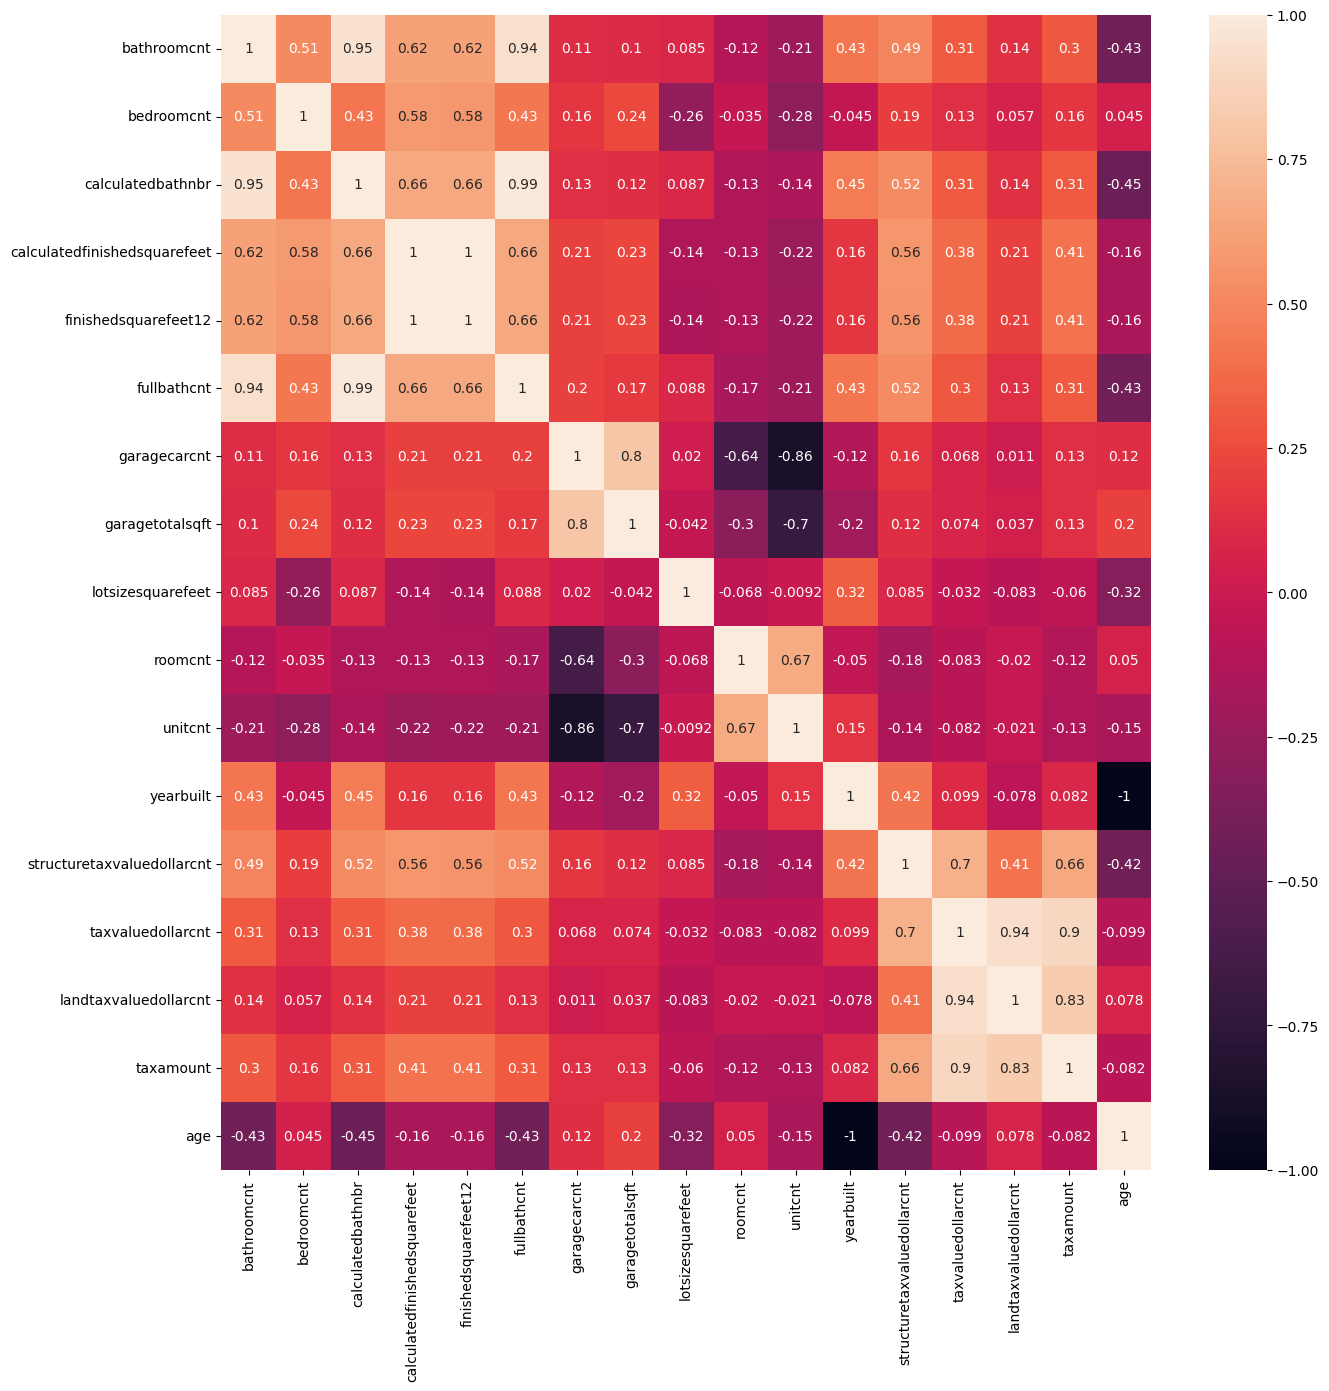

In [40]:
# X.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(data=X.corr(), annot=True)

In [41]:
X.drop('yearbuilt', axis=1, inplace=True)
X_test.drop('yearbuilt', axis=1, inplace=True)

X.drop('unitcnt', axis=1, inplace=True)
X_test.drop('unitcnt', axis=1, inplace=True)

Model Training

In [42]:
import optuna
from sklearn.metrics import mean_squared_error
from math import sqrt

def optimizer(trial, X, y, K):
    
    # learning_rate = trial.suggest_float('learning_rate', 0.001, 0.01)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True) 
    # For CPU
    n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 200])
    # For GPU
#     n_estimators = trial.suggest_categorical('n_estimators', [250, 500])
    min_child_samples = trial.suggest_categorical('min_child_samples', [10, 20, 50])
#    max_depth = trial.suggest_int('max_depth', 4, 8)
    num_leaves = trial.suggest_categorical('num_leaves', [2**6-1, # 63
                                                          2**7-1, # 127
                                                          2**8-1, # 255
                                                          2**9-1])# 511
    


    # LGBM
    model = LGBMRegressor(learning_rate=learning_rate,
                           n_estimators=n_estimators,
                           min_child_samples=min_child_samples,
                           num_leaves=num_leaves,
#                           max_depth=max_depth,
#                           max_bin = 128,
                           random_state=42,
                           verbose=-1,
#                            device='gpu'
                          )
    
    
    # K-Fold Cross validation
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = sqrt(mean_squared_error(y_val, preds))
        losses.append(loss)
    
    
    # Return average loss value of K-Fold
    return np.mean(losses)

In [43]:
from sklearn.model_selection import KFold
from functools import partial

In [44]:
K = 5 # Kfold
opt_func = partial(optimizer, X=X, y=y_train, K=K)

study = optuna.create_study(direction="minimize")
study.optimize(opt_func, n_trials=50)

[I 2023-05-09 13:01:23,507] A new study created in memory with name: no-name-b820f9f7-1c48-436e-9561-7ded8b3d1078
[I 2023-05-09 13:01:34,935] Trial 0 finished with value: 0.049733884034376216 and parameters: {'learning_rate': 0.0014356719660451372, 'n_estimators': 50, 'min_child_samples': 50, 'num_leaves': 511}. Best is trial 0 with value: 0.049733884034376216.
[I 2023-05-09 13:01:57,434] Trial 1 finished with value: 0.04956428419085316 and parameters: {'learning_rate': 0.022644568967035324, 'n_estimators': 100, 'min_child_samples': 20, 'num_leaves': 511}. Best is trial 1 with value: 0.04956428419085316.
[I 2023-05-09 13:02:11,995] Trial 2 finished with value: 0.04928327767927109 and parameters: {'learning_rate': 0.010606301154392251, 'n_estimators': 100, 'min_child_samples': 50, 'num_leaves': 255}. Best is trial 2 with value: 0.04928327767927109.
[I 2023-05-09 13:02:36,483] Trial 3 finished with value: 0.050038187752204547 and parameters: {'learning_rate': 0.03715919254685868, 'n_esti

In [45]:
print("Best Score: %.4f" % study.best_value) # best score
print("Best params: ", study.best_trial.params)

Best Score: 0.0493
Best params:  {'learning_rate': 0.009957574554249471, 'n_estimators': 100, 'min_child_samples': 50, 'num_leaves': 511}


In [46]:
# model finalization
best_params = study.best_trial.params
best_model = LGBMRegressor(**best_params)
best_model.fit(X, y_train)

result = best_model.predict(X_test)
# result
# sqrt(mean_squared_error(test_y, result))


# submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")
# submission

# submission["Transported"] = result
# submission.to_csv("submission.csv", index=False)
# submission

In [47]:
len(result)

1706226

In [48]:
sample = pd.read_csv("/kaggle/input/zillow-prize-1/sample_submission.csv")
sample.head()
sample.tail()

,ParcelId,201610,201611,201612,201710,201711,201712
2985212,168176230,0,0,0,0,0,0
2985213,14273630,0,0,0,0,0,0
2985214,168040630,0,0,0,0,0,0
2985215,168040830,0,0,0,0,0,0
2985216,168040430,0,0,0,0,0,0


In [49]:
# submission = pd.read_csv("/kaggle/input/zillow-prize-1/sample_submission.csv")

# for col in submission:
#     if col != 'ParcelId':
#         submission[col] = result 

In [50]:
# submission.head()

In [51]:
# !ls -l /kaggle/working

In [52]:
# submission.to_csv('submission.csv', index=False)

In [53]:
# saved = pd.read_csv('submission.csv')

In [54]:
# saved.head()

In [55]:
# y_train.shape

Visualization of the influence of characterstics

In [56]:
# sort_index = best_model.feature_importances_.argsort()
# plt.bar(x= X.columns[sort_index], height = best_model.feature_importances_[sort_index])
# plt.xticks(rotation=90)
# plt.show()